In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
df = pd.read_csv('data_model.csv')

In [3]:
df.head()

,nombre,Ciencias naturales-nota_p1,Ciencias naturales-nota_p2,Ciencias naturales-nota_p3,Ciencias naturales-nota_p4,Ciencias sociales-nota_p1,Ciencias sociales-nota_p2,Ciencias sociales-nota_p3,Ciencias sociales-nota_p4,Educación artística-nota_p1,...,Tecnología e informática-nota_p3,Tecnología e informática-nota_p4,Humanidades-nota_p1,Humanidades-nota_p2,Humanidades-nota_p3,Humanidades-nota_p4,fecha,segment,firstLabel,secondLabel
0,ACEVEDO MOLANO MATIAS,3.0,4.0,4.0,4.0,3.0,4.0,4.0,4.0,3.0,...,3.0,3.0,3.0,3.0,3.0,4.0,2021-03-01,SEGUNDO,GreenFlag,WhiteFlag
1,ACEVEDO MOLANO THOMAS,3.0,4.0,4.0,4.0,3.0,3.0,3.0,4.0,3.0,...,3.0,3.0,3.0,3.0,3.0,3.0,2021-03-01,QUINTO,GreenFlag,WhiteFlag
2,ACEVEDO VELEZ MARIA FERNANDA,3.0,3.0,4.0,4.0,4.0,3.0,2.0,3.0,3.0,...,2.0,4.0,3.0,3.0,3.0,3.0,2021-03-01,DIEZ,GreenFlag,YellowFlag
3,ACOSTA BASTO SARA SOFIA,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,3.0,3.0,3.0,4.0,4.0,3.0,2021-03-01,TERCERO,GreenFlag,WhiteFlag
4,AGUDELO ARANGO FEDERICO,4.0,2.0,2.0,2.0,4.0,3.0,2.0,2.0,4.0,...,4.0,4.0,3.0,2.0,2.0,3.0,2021-03-01,OCHO,GreenFlag,OrangeFlag


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26363 entries, 0 to 26362
Data columns (total 45 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   nombre                              26363 non-null  object 
 1   Ciencias naturales-nota_p1          26363 non-null  float64
 2   Ciencias naturales-nota_p2          26363 non-null  float64
 3   Ciencias naturales-nota_p3          26363 non-null  float64
 4   Ciencias naturales-nota_p4          26363 non-null  float64
 5   Ciencias sociales-nota_p1           26363 non-null  float64
 6   Ciencias sociales-nota_p2           26363 non-null  float64
 7   Ciencias sociales-nota_p3           26363 non-null  float64
 8   Ciencias sociales-nota_p4           26363 non-null  float64
 9   Educación artística-nota_p1         26363 non-null  float64
 10  Educación artística-nota_p2         26363 non-null  float64
 11  Educación artística-nota_p3         26363

# MODELOS

In [5]:
def data_split(examples, labels, train_frac, random_state=None):
    ''' https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
    param data:       Data to be split
    param train_frac: Ratio of train set to whole dataset

    Randomly split dataset, based on these ratios:
        'train': train_frac
        'valid': (1-train_frac) / 2
        'test':  (1-train_frac) / 2

    Eg: passing train_frac=0.8 gives a 80% / 10% / 10% split
    '''

    assert train_frac >= 0 and train_frac <= 1, "Invalid training set fraction"

    X_train, X_tmp, Y_train, Y_tmp = train_test_split(
                                        examples, labels, train_size=train_frac, random_state=random_state)

    X_val, X_test, Y_val, Y_test   = train_test_split(
                                        X_tmp, Y_tmp, train_size=0.5, random_state=random_state)

    return X_train, X_val, X_test,  Y_train, Y_val, Y_test

In [6]:
def confu_matrix(y_test,y_pred):
	df = pd.DataFrame(list(zip(y_test,y_pred)), columns = ['y_test','y_pred'])
	confusion_matrix = pd.crosstab(df['y_test'], df['y_pred'], rownames=['Actual'], colnames=['Predicted'])
	sns.heatmap(confusion_matrix, annot=True)
	plt.show()

## XGBClassifier

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from imblearn.combine import SMOTETomek
from sklearn.metrics import classification_report

### Primer modelo con la firtLabel 

In [125]:
X = df.drop(['fecha','firstLabel','secondLabel','nombre'],axis=1)
y = df['firstLabel']
#Dummy variable for ‘segment’ column
segment = pd.get_dummies(X['segment'], drop_first = True)
#Dropping the original ‘segment’
X = X.drop(['segment'], axis = 1)
#Adding the dummy columns to the dataset
X = pd.concat([X,segment], axis = 1)

y = y.replace(['GreenFlag', 'WhiteFlag', 'YellowFlag', 'OrangeFlag', 'RedFlag'],[0,1,2,3,4])

X_train, X_val, X_test, y_train, y_val, y_test = data_split(X,y,0.7)
os_us = SMOTETomek()
X_train_, y_train_ = os_us.fit_resample(X_train, y_train)

<AxesSubplot:title={'center':'Balanceados'}>

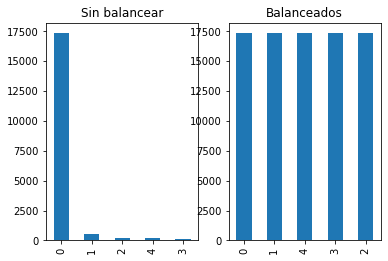

In [126]:
plt.show()
plt.subplot(221)
plt.subplot(1, 2, 1)
y_train.value_counts().plot(kind='bar',title='Sin balancear')
plt.subplot(1, 2, 2)
y_train_.value_counts().plot(kind='bar',title='Balanceados')

In [127]:
X = df.drop(['fecha','firstLabel','secondLabel','nombre'],axis=1)
y = df['firstLabel']
#Dummy variable for ‘segment’ column
segment = pd.get_dummies(X['segment'], drop_first = True)
#Dropping the original ‘segment’
X = X.drop(['segment'], axis = 1)
#Adding the dummy columns to the dataset
X = pd.concat([X,segment], axis = 1)
y = y.replace(['GreenFlag', 'WhiteFlag', 'YellowFlag', 'OrangeFlag', 'RedFlag'],[0,1,2,3,4])

X_train, X_val, X_test, y_train, y_val, y_test = data_split(X,y,0.7)
os_us = SMOTETomek()
X_train_, y_train_ = os_us.fit_resample(X_train, y_train)

model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
model.fit(X_train_, y_train_)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('accuracy:',accuracy)

accuracy: 0.9463969658659924


In [128]:
report = classification_report(y_test,y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      3709
           1       0.27      0.11      0.16       123
           2       0.32      0.12      0.18        57
           3       0.45      0.21      0.29        24
           4       0.67      0.62      0.64        42

    accuracy                           0.95      3955
   macro avg       0.53      0.41      0.45      3955
weighted avg       0.93      0.95      0.93      3955



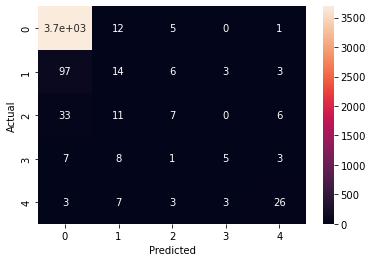

In [129]:
confu_matrix(y_test,y_pred)

### Optimization

In [ ]:
X = df.drop(['fecha','firstLabel','secondLabel','nombre'],axis=1)
y = df['firstLabel']
#Dummy variable for ‘segment’ column
segment = pd.get_dummies(X['segment'], drop_first = True)
#Dropping the original ‘segment’
X = X.drop(['segment'], axis = 1)
#Adding the dummy columns to the dataset
X = pd.concat([X,segment], axis = 1)
y = y.replace(['GreenFlag', 'WhiteFlag', 'YellowFlag', 'OrangeFlag', 'RedFlag'],[0,1,2,3,4])

# Split data into train and test sets
X_train, X_val, X_test, y_train, y_val, y_test = data_split(X,y,0.7)
os_us = SMOTETomek()
X_train_, y_train_ = os_us.fit_resample(X_train, y_train)

'''
# Define the model
xgb_model = XGBClassifier()

# Define the parameter grid
param_grid = {
    'max_depth': np.arange(3, 10, 2),
    'learning_rate': [0.05, 0.1, 0.15, 0.2],
    'n_estimators': [50, 100, 150, 200],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.5, 1],
    'reg_lambda': [1, 1.5, 2],
    'scale_pos_weight': [1, 2, 3, 4],
    'min_child_weight': [1, 2, 3]
}

# Define the random search
random_search = RandomizedSearchCV(xgb_model, param_distributions=param_grid, n_iter=100, cv=5, 
                                   scoring='f1_micro', n_jobs=-1, random_state=42)

# Fit the random search
random_search.fit(X_train_, y_train_)

# Print the best parameters
print(random_search.best_params_)
'''

In [134]:
X = df.drop(['fecha','firstLabel','secondLabel','nombre'],axis=1)
y = df['firstLabel']
#Dummy variable for ‘segment’ column
segment = pd.get_dummies(X['segment'], drop_first = True)
#Dropping the original ‘segment’
X = X.drop(['segment'], axis = 1)
#Adding the dummy columns to the dataset
X = pd.concat([X,segment], axis = 1)
y = y.replace(['GreenFlag', 'WhiteFlag', 'YellowFlag', 'OrangeFlag', 'RedFlag'],[0,1,2,3,4])

X_train, X_val, X_test, y_train, y_val, y_test = data_split(X,y,0.7)
os_us = SMOTETomek()
X_train_, y_train_ = os_us.fit_resample(X_train, y_train)

model = XGBClassifier(subsample=0.8, scale_pos_weight=2, reg_lambda=2, 
                      reg_alpha=0, n_estimators=100, min_child_weight=1, 
                      max_depth=9, learning_rate=0.1, colsample_bytree=1.0)
model.fit(X_train_, y_train_)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('accuracy:',accuracy)

[10:33:48] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


accuracy: 0.9453855878634639


In [135]:
report = classification_report(y_test,y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      3707
           1       0.28      0.10      0.15       121
           2       0.20      0.07      0.11        55
           3       0.27      0.11      0.15        28
           4       0.74      0.57      0.64        44

    accuracy                           0.95      3955
   macro avg       0.49      0.37      0.41      3955
weighted avg       0.92      0.95      0.93      3955



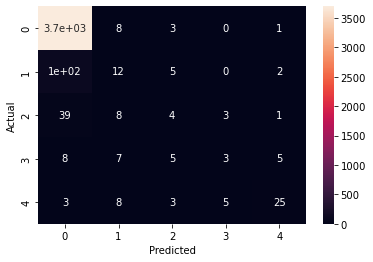

In [136]:
confu_matrix(y_test,y_pred)

### Segundo modelo con la secondLabel 

<AxesSubplot:title={'center':'Balanceados'}>

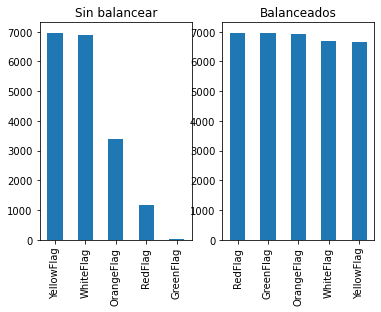

In [11]:
X = df.drop(['fecha','firstLabel','secondLabel','nombre'],axis=1)
y = df['secondLabel']
#Dummy variable for ‘segment’ column
segment = pd.get_dummies(X['segment'], drop_first = True)
#Dropping the original ‘segment’
X = X.drop(['segment'], axis = 1)
#Adding the dummy columns to the dataset
X = pd.concat([X,segment], axis = 1)

#y = y.replace(['GreenFlag', 'WhiteFlag', 'YellowFlag', 'OrangeFlag', 'RedFlag'],[0,1,2,3,4])

X_train, X_val, X_test, y_train, y_val, y_test = data_split(X,y,0.7)
os_us = SMOTETomek()
X_train_, y_train_ = os_us.fit_resample(X_train, y_train)

plt.show()
plt.subplot(221)
plt.subplot(1, 2, 1)
y_train.value_counts().plot(kind='bar',title='Sin balancear')
plt.subplot(1, 2, 2)
y_train_.value_counts().plot(kind='bar',title='Balanceados')

<AxesSubplot:title={'center':'Balanceados'}>

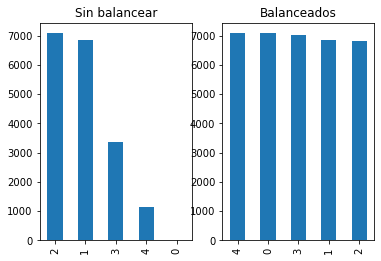

In [12]:
X = df.drop(['fecha','firstLabel','secondLabel','nombre'],axis=1)
y = df['secondLabel']
#Dummy variable for ‘segment’ column
segment = pd.get_dummies(X['segment'], drop_first = True)
#Dropping the original ‘segment’
X = X.drop(['segment'], axis = 1)
#Adding the dummy columns to the dataset
X = pd.concat([X,segment], axis = 1)

y = y.replace(['GreenFlag', 'WhiteFlag', 'YellowFlag', 'OrangeFlag', 'RedFlag'],[0,1,2,3,4])

X_train, X_val, X_test, y_train, y_val, y_test = data_split(X,y,0.7)
os_us = SMOTETomek()
X_train_, y_train_ = os_us.fit_resample(X_train, y_train)

plt.show()
plt.subplot(221)
plt.subplot(1, 2, 1)
y_train.value_counts().plot(kind='bar',title='Sin balancear')
plt.subplot(1, 2, 2)
y_train_.value_counts().plot(kind='bar',title='Balanceados')

In [28]:
X = df.drop(['fecha','firstLabel','secondLabel','nombre'],axis=1)
y = df['secondLabel']
#Dummy variable for ‘segment’ column
segment = pd.get_dummies(X['segment'], drop_first = True)
#Dropping the original ‘segment’
X = X.drop(['segment'], axis = 1)
#Adding the dummy columns to the dataset
X = pd.concat([X,segment], axis = 1)
y = y.replace(['GreenFlag', 'WhiteFlag', 'YellowFlag', 'OrangeFlag', 'RedFlag'],[0,1,2,3,4])

X_train, X_val, X_test, y_train, y_val, y_test = data_split(X,y,0.7)
os_us = SMOTETomek()
X_train_, y_train_ = os_us.fit_resample(X_train, y_train)

model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
model.fit(X_train_, y_train_)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('accuracy:',accuracy)

accuracy: 0.9221238938053097


In [13]:
y_train.value_counts()

2    7079
1    6850
3    3376
4    1135
0      14
Name: secondLabel, dtype: int64

In [29]:
report_sinOptimizar = classification_report(y_test,y_pred)
print(report_sinOptimizar)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       0.99      0.98      0.99      1451
           2       0.92      0.95      0.93      1517
           3       0.82      0.82      0.82       746
           4       0.82      0.71      0.76       239

    accuracy                           0.92      3955
   macro avg       0.91      0.89      0.90      3955
weighted avg       0.92      0.92      0.92      3955



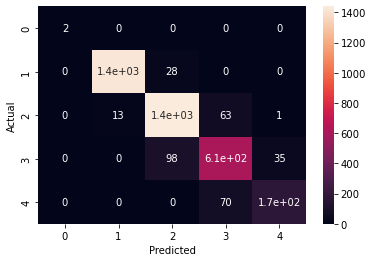

In [35]:
confu_matrix(y_test,y_pred)

### Optimization

In [ ]:
X = df.drop(['fecha','firstLabel','secondLabel','nombre'],axis=1)
y = df['secondLabel']
#Dummy variable for ‘segment’ column
segment = pd.get_dummies(X['segment'], drop_first = True)
#Dropping the original ‘segment’
X = X.drop(['segment'], axis = 1)
#Adding the dummy columns to the dataset
X = pd.concat([X,segment], axis = 1)
y = y.replace(['GreenFlag', 'WhiteFlag', 'YellowFlag', 'OrangeFlag', 'RedFlag'],[0,1,2,3,4])

# Split data into train and test sets
X_train, X_val, X_test, y_train, y_val, y_test = data_split(X,y,0.7)
os_us = SMOTETomek()
X_train_, y_train_ = os_us.fit_resample(X_train, y_train)

'''
# Define the model
xgb_model = XGBClassifier()

# Define the parameter grid
param_grid = {
    'max_depth': np.arange(3, 10, 2),
    'learning_rate': [0.05, 0.1, 0.15, 0.2],
    'n_estimators': [50, 100, 150, 200],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.5, 1],
    'reg_lambda': [1, 1.5, 2],
    'scale_pos_weight': [1, 2, 3, 4],
    'min_child_weight': [1, 2, 3]
}

# Define the random search
random_search = RandomizedSearchCV(xgb_model, param_distributions=param_grid, n_iter=100, cv=5, 
                                   scoring='f1_micro', n_jobs=-1, random_state=42)

# Fit the random search
random_search.fit(X_train_, y_train_)

# Print the best parameters
print(random_search.best_params_)
'''

In [150]:
X = df.drop(['fecha','firstLabel','secondLabel','nombre'],axis=1)
y = df['secondLabel']
#Dummy variable for ‘segment’ column
segment = pd.get_dummies(X['segment'], drop_first = True)
#Dropping the original ‘segment’
X = X.drop(['segment'], axis = 1)
#Adding the dummy columns to the dataset
X = pd.concat([X,segment], axis = 1)
y = y.replace(['GreenFlag', 'WhiteFlag', 'YellowFlag', 'OrangeFlag', 'RedFlag'],[0,1,2,3,4])

X_train, X_val, X_test, y_train, y_val, y_test = data_split(X,y,0.7)
os_us = SMOTETomek()
X_train_, y_train_ = os_us.fit_resample(X_train, y_train)

model = XGBClassifier(subsample=1.0, scale_pos_weight=3, reg_lambda=2, 
                      reg_alpha=0.5, n_estimators=150, min_child_weight=1, 
                      max_depth=7, learning_rate=0.2, colsample_bytree=1.0)
model.fit(X_train_, y_train_)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('accuracy:',accuracy)

[10:51:32] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


accuracy: 0.9236409608091024


In [151]:
report_optimizado = classification_report(y_test,y_pred)
print(report_optimizado)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.99      0.99      0.99      1512
           2       0.91      0.96      0.94      1454
           3       0.81      0.81      0.81       729
           4       0.86      0.64      0.74       259

    accuracy                           0.92      3955
   macro avg       0.72      0.68      0.70      3955
weighted avg       0.92      0.92      0.92      3955



/Users/nestorsanchez/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nestorsanchez/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nestorsanchez/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

In [152]:
print(report_sinOptimizar)

              precision    recall  f1-score   support

           0       0.67      0.50      0.57         4
           1       0.99      0.99      0.99      1480
           2       0.93      0.95      0.94      1555
           3       0.81      0.81      0.81       679
           4       0.83      0.68      0.75       237

    accuracy                           0.93      3955
   macro avg       0.84      0.79      0.81      3955
weighted avg       0.93      0.93      0.93      3955



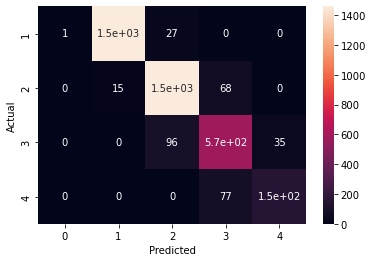

In [147]:
confu_matrix(y_test,y_pred)